In [7]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle
import os
import pandas as pd

from spec_utils import read_irs

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


### Plot the 13CO2 and 12CO2 models, and find their peaks

In [8]:
out_13co2=pickle.load(open('models/13co2_1e19_500_1au2_1pc_irs.p','rb'))

In [9]:
from scipy.signal import find_peaks
peaks = find_peaks(out_13co2['spectrum']['convolflux'], height=20)
peak13 = out_13co2['spectrum']['wave'][peaks[0][0]] # peak of graph

Text(0, 0.5, 'Flux (Jy)')

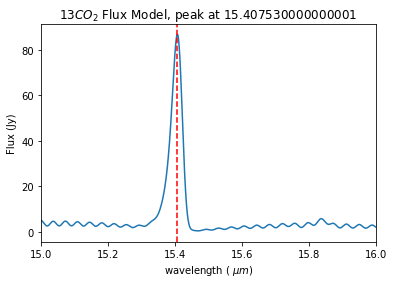

In [10]:
plt.plot(out_13co2['spectrum']['wave'],out_13co2['spectrum']['convolflux'])
plt.axvline(x=peak13, color='r', ls='--')
plt.xlim(15, 16)
plt.title("13$CO_2$ Flux Model, peak at " + str(peak13))
plt.xlabel('wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')

In [11]:
out_12co2=pickle.load(open('models/co2_1e19_500_1au2_1pc_irs.p','rb'))

In [12]:
peaks12 = find_peaks(out_12co2['spectrum']['convolflux'], height=20)
peak12 = out_12co2['spectrum']['wave'][peaks12[0][0]] # peak of graph

Text(0, 0.5, 'Flux (Jy)')

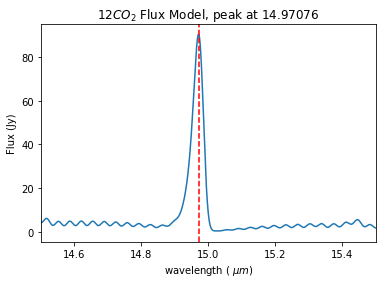

In [13]:
plt.plot(out_12co2['spectrum']['wave'],out_12co2['spectrum']['convolflux'])
plt.axvline(x=peak12, color='r', ls='--')
plt.xlim(14.5, 15.5)
plt.title("12$CO_2$ Flux Model, peak at " + str(peak12))
plt.xlabel('wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')

### Water Model to plot on top of figures

In [14]:
out_h2o=pickle.load(open('models/h2o_1e22_500_1au2_1pc_irs.p','rb'))

Text(0, 0.5, 'Flux (Jy)')

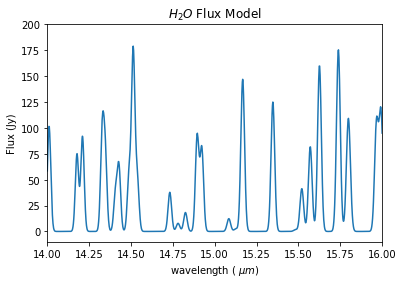

In [15]:
plt.plot(out_h2o['spectrum']['wave'],out_h2o['spectrum']['convolflux'])
plt.xlim(14, 16)
plt.ylim(-10, 200)
plt.title("$H_2 O$ Flux Model")
plt.xlabel('wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')

#### Try plotting against DR Tau, which we know is water-rich

(-0.01, 0.2)

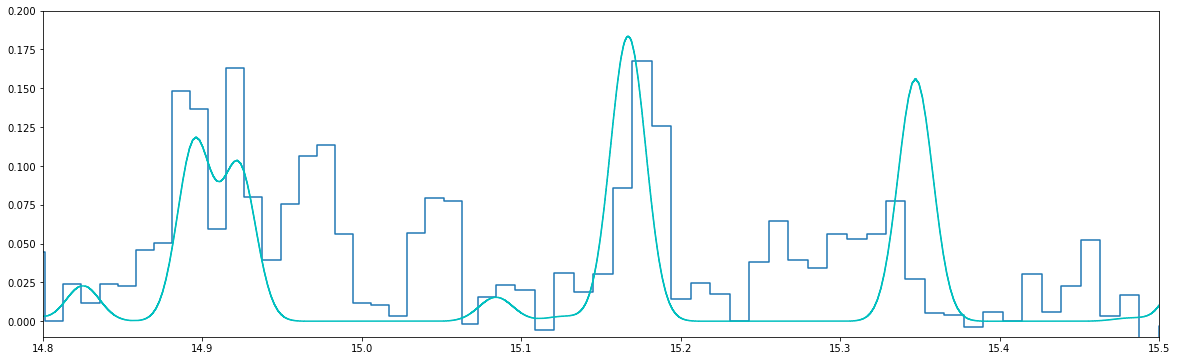

In [16]:
path = os.getcwd() + '/REDUCED/'
drtau=read_irs('DRTAU',dd=path,noerror=True)
plt.figure(figsize = (20, 6))
plt.plot(drtau.wave,drtau.flux, drawstyle='steps-mid')

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 800
plt.plot(xh2o, yh2o, color='c', drawstyle='steps-mid')

plt.xlim(14.8, 15.5)
plt.ylim(-0.01, .2)

### Now I'll try plotting 12CO2 (to compare) and 13CO2 values

#### IM Lup: 12CO2 flux value for GW Lup should be around 8.60E-18 from Salyk et al. 2011

(-0.01, 0.04)

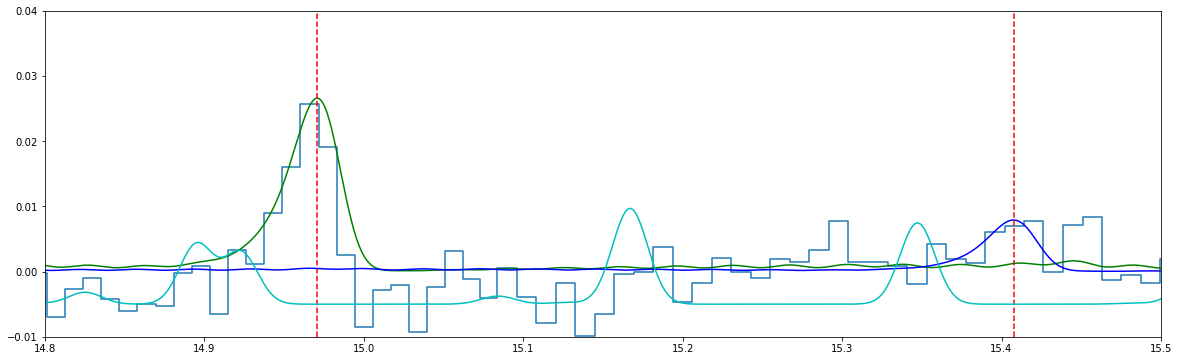

In [17]:
# IM Lup

x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 3400

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 11000

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 10000 - 0.005

imlup=read_irs('IMLUP',dd=path,noerror=True)

plt.figure(figsize = (20, 6))
plt.plot(imlup.wave,imlup.flux, drawstyle='steps-mid')

plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.5)
plt.ylim(-0.01, .04)

#### RY LUP: 12CO2 flux value found to be around 1.12E-17 by Salyk et al. 2011 

(-0.03, 0.05)

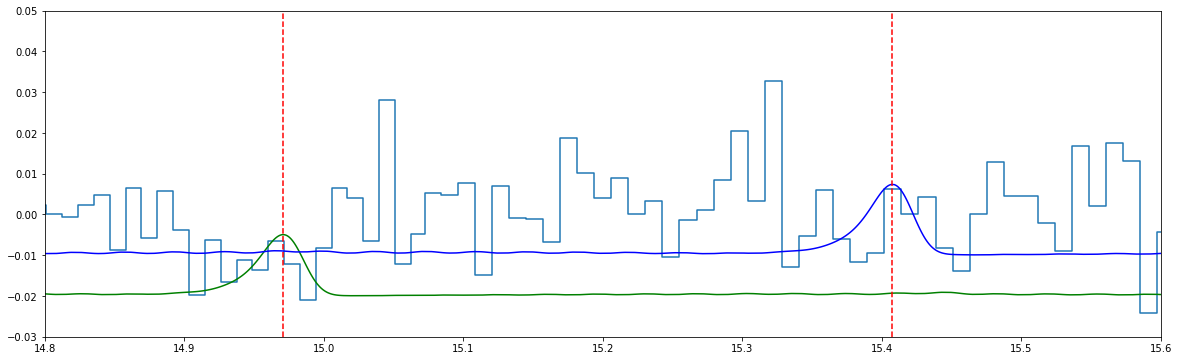

In [18]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 6000 - 0.02

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 5000 - 0.01

rylup=read_irs('RYLUP',dd=path,noerror=True)

plt.figure(figsize = (20, 6))
plt.plot(rylup.wave,rylup.flux, drawstyle='steps-mid')

plt.plot(x, y, color='g', drawstyle='steps-mid')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b', drawstyle='steps-mid')
plt.axvline(x=peak13, color='r', ls='--')

plt.xlim(14.8, 15.6)
plt.ylim(-0.03, 0.05)


#### IRAS 04385 12CO2 value found to be around 3.26E-17 (URSI calculated)

(-0.01, 0.05)

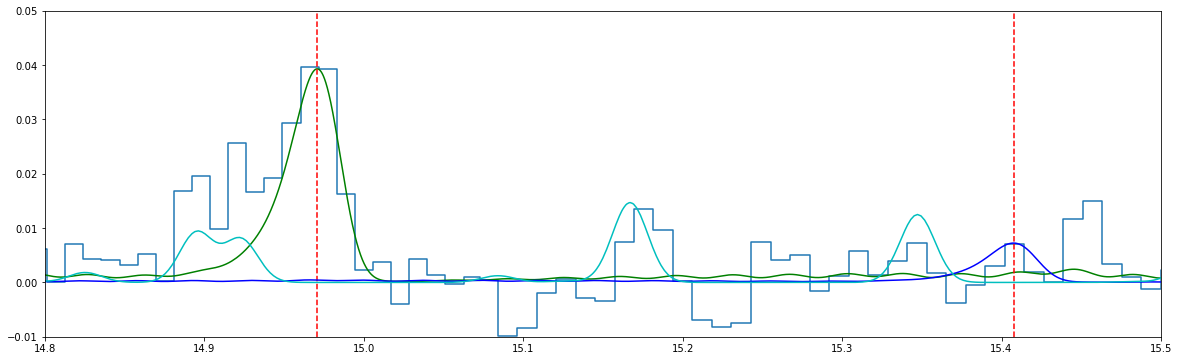

In [19]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 2300

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 12000

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 10000

iras=read_irs('04385+2550',dd=path,noerror=True)

plt.figure(figsize = (20, 6))
plt.plot(iras.wave,iras.flux, drawstyle='steps-mid')

plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.5)
plt.ylim(-0.01, .05)

#### AS 209 12CO2 value found to be around 1.81E-16 (URSI calculated)

(-0.1, 0.2)

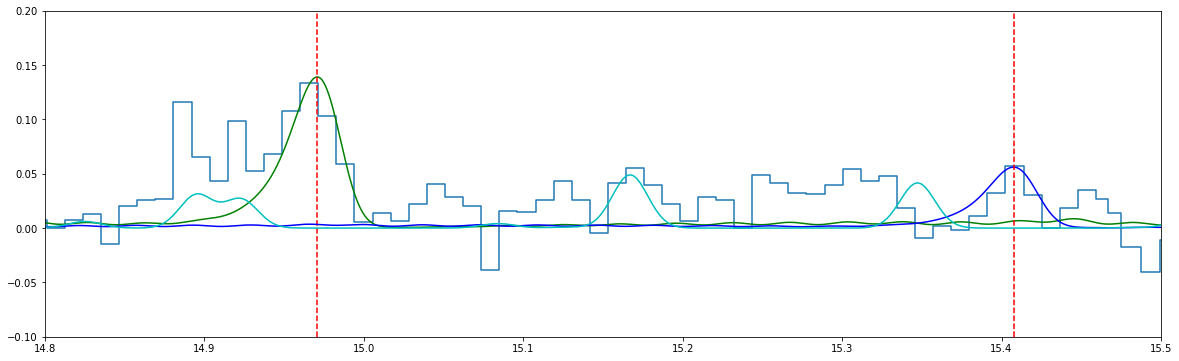

In [20]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 650

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 1550

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 3000

as209=read_irs('V1121OPH',dd=path,noerror=True)

plt.figure(figsize = (20, 6))
plt.plot(as209.wave,as209.flux, drawstyle='steps-mid')

plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.5)
plt.ylim(-0.1, 0.2)

### Combining spectra with 13CO2 signals

In [21]:
from scipy.interpolate import interp1d

imlup_f = interp1d(imlup.wave,imlup.flux)
iras_f = interp1d(iras.wave,iras.flux)
as209_f = interp1d(as209.wave,as209.flux)

#### Method 1: Adding the spectra together

In [22]:
xvals = np.linspace(14.8, 15.6, 1000)
add = imlup_f(xvals) + iras_f(xvals) + as209_f(xvals)

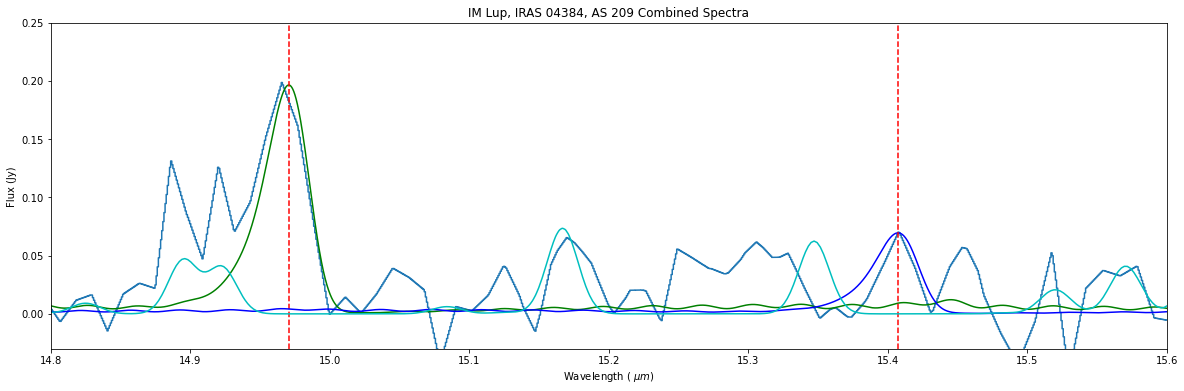

In [41]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 460

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 1250

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 2000

plt.figure(figsize = (20, 6))
plt.plot(xvals, add, drawstyle='steps-mid')
plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.6)
plt.ylim(-0.03, 0.25)

plt.title("IM Lup, IRAS 04384, AS 209 Combined Spectra")
plt.xlabel('Wavelength ( $\mu m$)')
plt.ylabel('Flux (Jy)')
plt.savefig(os.getcwd() + '/plots/addedCO2.png')

#### Method 2: Weighting by strength of 12CO2 signal

In [24]:
imlup12 = find_peaks(imlup.flux, height=0.02)
imlup12 = imlup12[1]['peak_heights'][0]

In [25]:
iras12 = find_peaks(iras.flux, height=0.03)
iras12 = iras12[1]['peak_heights'][0]

In [26]:
as209_12 = find_peaks(as209.flux, height=0.03)
as209_12 = as209_12[1]['peak_heights'][0]

In [27]:
denom12 = imlup12 + iras12 + as209_12
weighted12 = (imlup12/denom12)*imlup_f(xvals) + (iras12/denom12)*iras_f(xvals) + (as209_12/denom12)*as209_f(xvals)

(-0.03, 0.15)

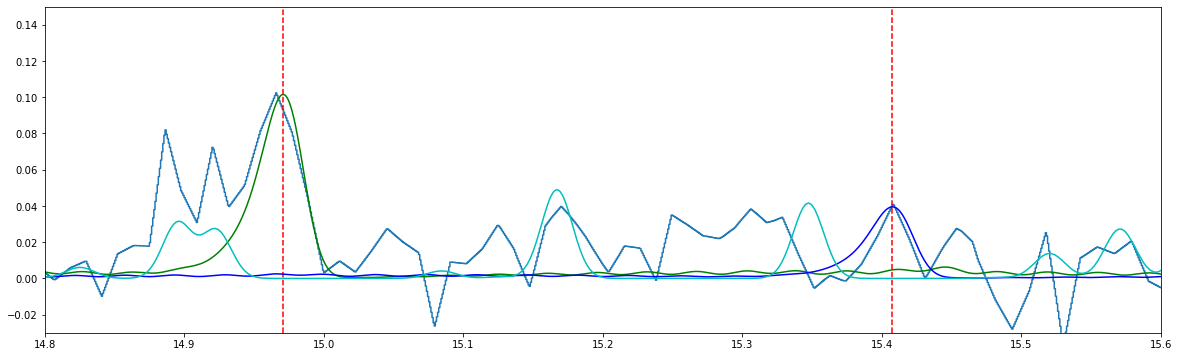

In [28]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 890

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 2200

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 3000

plt.figure(figsize = (20, 6))
plt.plot(xvals,weighted12, drawstyle='steps-mid')
plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.6)
plt.ylim(-0.03, 0.15)

#### Method 3: weighting by strength of 13CO2 

In [29]:
im_around_13 = imlup.flux.values[560:575]
imlup13 = find_peaks(im_around_13, height=0.003)
imlup13 = imlup13[1]['peak_heights'][1]
imlup13

0.007710853051317135

In [30]:
iras_around_13 = iras.flux.values[560:575]
iras13 = find_peaks(iras_around_13, height=0.002)
iras13 = iras13[1]['peak_heights'][1]
iras13

0.007097553892503772

In [31]:
as209_around_13 = as209.flux.values[580:590]
as209_13 = find_peaks(as209_around_13, height=0.002)
as209_13 = as209_13[1]['peak_heights'][0]
as209_13

0.05688252993819898

In [32]:
denom13 = imlup13 + iras13 + as209_13
weighted13 = (imlup13/denom13)*imlup_f(xvals) + (iras13/denom13)*iras_f(xvals) + (as209_13/denom13)*as209_f(xvals)

(-0.01, 0.15)

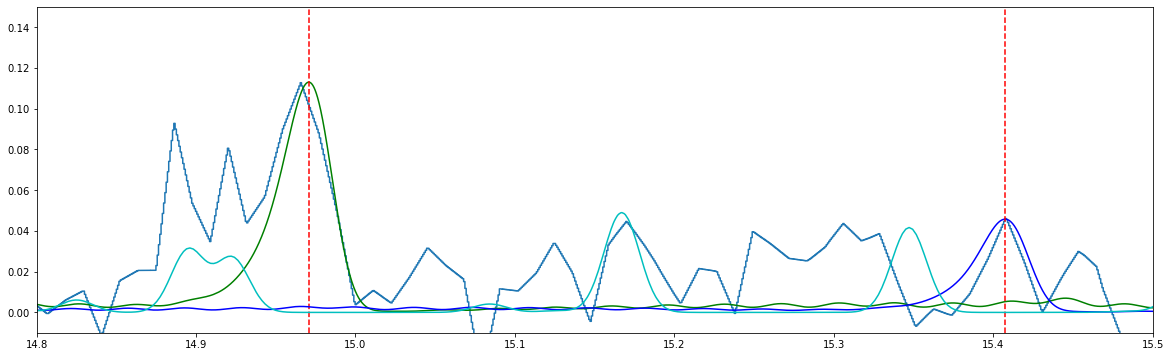

In [33]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 800

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 1900

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 3000

plt.figure(figsize = (20, 6))
plt.plot(xvals,weighted13, drawstyle='steps-mid')
plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.5)
plt.ylim(-0.01, .15)

#### Method 4: weighting by strength of 13CO2 / 12CO2 ratio

In [34]:
imlup_ratio = imlup13 / imlup12
iras_ratio = iras13 / iras12
as209_ratio = as209_13 / as209_12
ratio13 = imlup_ratio*imlup_f(xvals) + iras_ratio*iras_f(xvals) + as209_ratio*as209_f(xvals)

(-0.03, 0.1)

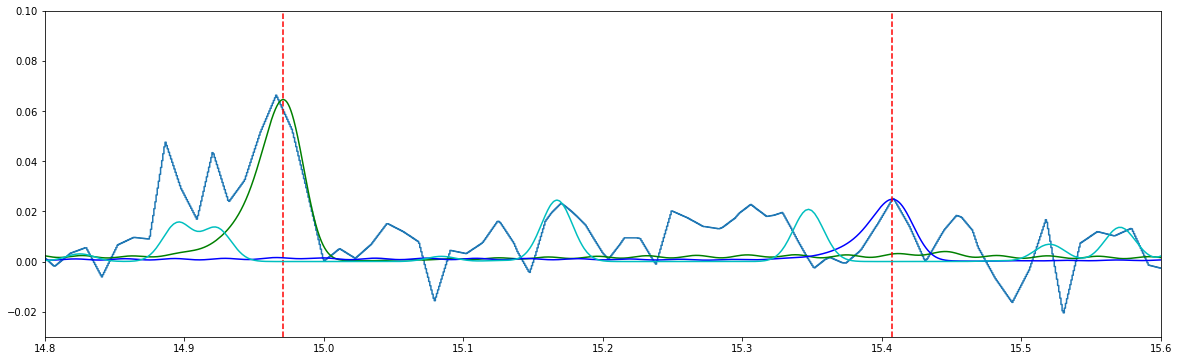

In [35]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 1400

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 3500

xh2o = out_h2o['spectrum']['wave']
yh2o = out_h2o['spectrum']['convolflux'] / 6000

plt.figure(figsize = (20, 6))
plt.plot(xvals,ratio13, drawstyle='steps-mid')
plt.plot(x, y, color='g')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o, yh2o, color='c')

plt.xlim(14.8, 15.6)
plt.ylim(-0.03, 0.1)

#### Method 5: give more weight to smaller 13CO2 signals

In [36]:
smaller_weighted = ((1/imlup13)*imlup_f(xvals) + (1/iras13)*iras_ratio*iras_f(xvals) + (1/as209_13)*as209_ratio*as209_f(xvals))/100

(-0.03, 0.1)

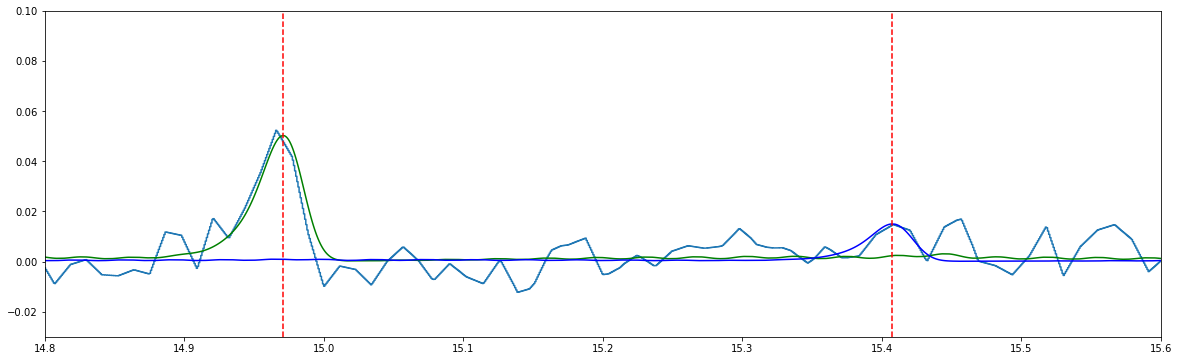

In [37]:
x = out_12co2['spectrum']['wave']
y = out_12co2['spectrum']['convolflux'] / 1800

x13 = out_13co2['spectrum']['wave']
y13 = out_13co2['spectrum']['convolflux'] / 5800

plt.figure(figsize = (20, 6))
plt.plot(xvals,smaller_weighted, drawstyle='steps-mid')
plt.plot(x, y, color='g', drawstyle='steps-mid')
plt.axvline(x=peak12, color='r', ls='--')

plt.plot(x13, y13, color='b', drawstyle='steps-mid')
plt.axvline(x=peak13, color='r', ls='--')
plt.xlim(14.8, 15.6)
plt.ylim(-0.03, 0.1)

## One Plot

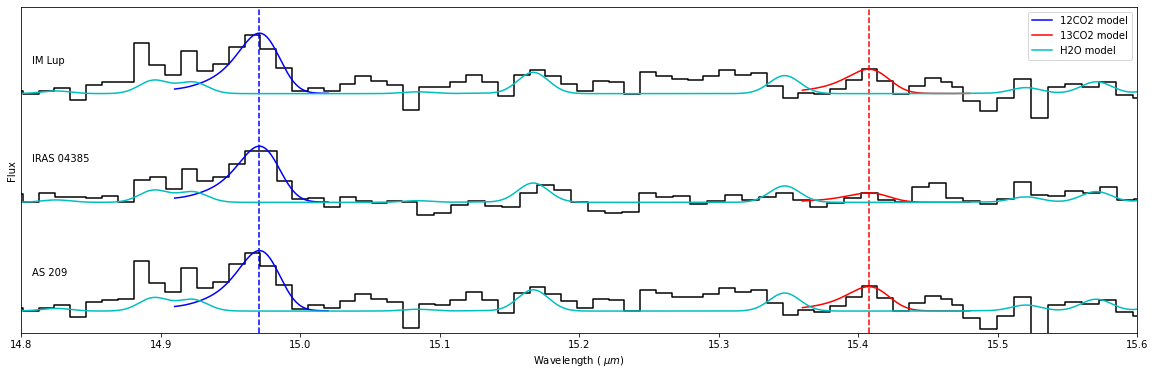

In [43]:
# IM Lup

x12_imlup = out_12co2['spectrum']['wave'][251000:262000]
y12_imlup = out_12co2['spectrum']['convolflux'][251000:262000] / 650

x13_imlup = out_13co2['spectrum']['wave'][296000:308000]
y13_imlup = out_13co2['spectrum']['convolflux'][296000:308000] / 1550

xh2o_imlup = out_h2o['spectrum']['wave']
yh2o_imlup = out_h2o['spectrum']['convolflux'] / 3000

as209=read_irs('V1121OPH',dd=path,noerror=True)

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(as209.wave,as209.flux, color = 'black', drawstyle='steps-mid')

plt.plot(x12_imlup, y12_imlup, color='b', label='12CO2 model')
plt.axvline(x=peak12, color='b', ls='--')

plt.plot(x13_imlup, y13_imlup, color='r', label='13CO2 model')
plt.axvline(x=peak13, color='r', ls='--')

plt.plot(xh2o_imlup, yh2o_imlup, color='c', label='H2O model')

# IRAS 04385
x12_iras = out_12co2['spectrum']['wave'][251000:262000]
y12_iras = out_12co2['spectrum']['convolflux'][251000:262000] / 700 - 0.25

x13_iras = out_13co2['spectrum']['wave'][296000:308000]
y13_iras = out_13co2['spectrum']['convolflux'][296000:308000] / 4000 - 0.25

xh2o_iras = out_h2o['spectrum']['wave']
yh2o_iras = out_h2o['spectrum']['convolflux'] / 3300 - 0.25

iras=read_irs('04385+2550',dd=path,noerror=True)

plt.plot(iras.wave,3*iras.flux - 0.25, color='black', drawstyle='steps-mid')

plt.plot(x12_iras, y12_iras, color='b')

plt.plot(x13_iras, y13_iras, color='r')

plt.plot(xh2o_iras, yh2o_iras, color='c')

# AS 209
x12_as209 = out_12co2['spectrum']['wave'][251000:262000]
y12_as209 = out_12co2['spectrum']['convolflux'][251000:262000] / 650 - 0.5

x13_as209 = out_13co2['spectrum']['wave'][296000:308000]
y13_as209 = out_13co2['spectrum']['convolflux'][296000:308000] / 1550 - 0.5

xh2o_as209 = out_h2o['spectrum']['wave']
yh2o_as209 = out_h2o['spectrum']['convolflux'] / 3000 - 0.5

as209=read_irs('V1121OPH',dd=path,noerror=True)

plt.plot(as209.wave,as209.flux - 0.5, color='black', drawstyle='steps-mid')

plt.plot(x12_as209, y12_as209, color='b')

plt.plot(x13_as209, y13_as209, color='r')

plt.plot(xh2o_as209, yh2o_as209, color='c')

plt.xlim(14.8, 15.6)
plt.ylim(-0.55, 0.2)

plt.xlabel('Wavelength ( $\mu m$)')
plt.ylabel('Flux')
plt.legend(loc="upper right")

plt.yticks([])

ax.text(0.01, .85, 'IM Lup',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

ax.text(0.01, .55, 'IRAS 04385',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

ax.text(0.01, .2, 'AS 209',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)


plt.savefig(os.getcwd() + '/plots/combinedCO2.png')